In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from datetime import datetime as dt
from matplotlib.ticker import ScalarFormatter
import squarify
import circlify

In [2]:
df = pd.read_csv('C:\\Users\\sarzy\\Documents\\Jupyter-lab\\2022 Parking Violations\\2021_parking_violations_cleaned_all_final.csv')

In [3]:
df.head()

,summons_number,registration_state,plate_type,issue_date,violation_fine,vehicle_body_type,vehicle_make,violation_precinct,issuer_code,violation_time,violation_county,house_number,street_name,vehicle_color,vehicle_year,violation,month_year,address
0,1471514882,NEW YORK,PASSENGER,2020-07-01,95.0,SUBURBAN,FORD,102,949909,12:00 PM,QUEENS,81-02,ROCKAWAY BLVD,WHITE,1998,OBSTRUCTING DRIVEWAY,JUL 2020,81-02 ROCKAWAY BLVD QUEENS
1,1471514894,NEW YORK,PASSENGER,2020-07-01,95.0,SUBURBAN,NISSA,102,949969,01:00 PM,QUEENS,87-34,132 ST,RED,2018,OBSTRUCTING DRIVEWAY,JUL 2020,87-34 132 ST QUEENS
2,1471514900,NEW YORK,PASSENGER,2020-07-01,95.0,SUBURBAN,INFIN,102,949969,02:00 PM,QUEENS,87-45,112 ST,BLACK,2004,OBSTRUCTING DRIVEWAY,JUL 2020,87-45 112 ST QUEENS
3,1473991845,NEW YORK,PASSENGER,2020-07-01,115.0,SUBURBAN,INFIN,40,952829,04:00 PM,BRONX,418,E 138 ST,BLACK,2008,BIKE LANE,JUL 2020,418 E 138 ST BRONX
4,1473991857,NEW YORK,PASSENGER,2020-07-01,115.0,SUBURBAN,HYUN,40,952829,04:00 PM,BRONX,416,E 138 ST,WHITE,2012,BIKE LANE,JUL 2020,416 E 138 ST BRONX


In [4]:
total_revenue = df.violation_fine.sum()
print('Total Number of Parking Violations in NYC Fiscal Year 2021:' , '{:,}'.format(len(df)))
print('Estimated Total Revenue: ' + '$' + '{:,}'.format(int(total_revenue)))

Total Number of Parking Violations in NYC Fiscal Year 2021: 6,578,587
Estimated Total Revenue: $483,212,847


### Table of Violations by Registration State.
###### '99' is equivalent to 'no state indicated'

In [5]:
states_table = pd.DataFrame(df.registration_state.value_counts())
states_table.sort_values('registration_state', ascending = False, inplace = True)
states_table.head(10)

,registration_state
NEW YORK,6548070
NEW JERSEY,8963
99,6024
TEXAS,4719
PENNSYLVANIA,2881
FLORIDA,1099
CONNECTICUT,993
MAINE,737
MASSACHUSETTS,602
VIRGINIA,580


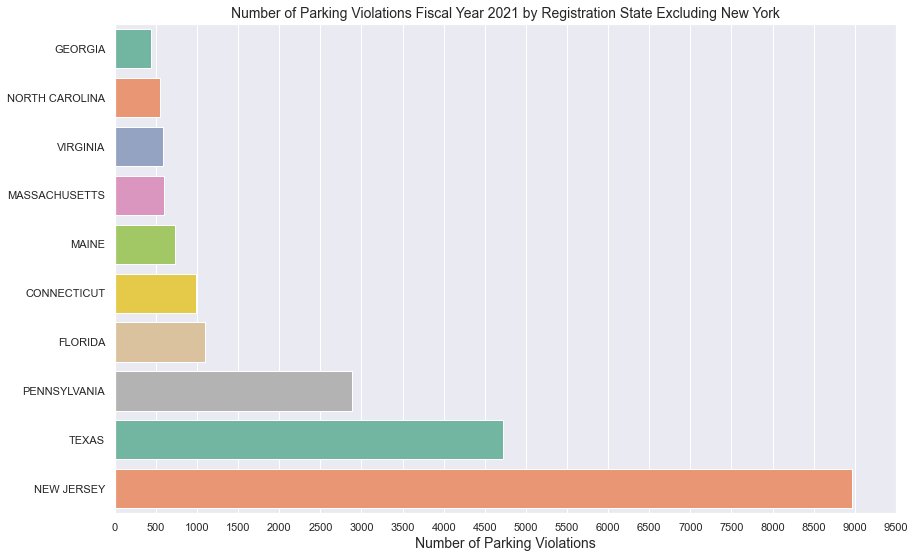

In [6]:
#Add % of total count of tickets next to bar? or convert to stacked bar plot?
states_df = df[(df['registration_state'] != 'NEW YORK') & (df['registration_state'] != '99')]
states = pd.DataFrame(states_df.registration_state.value_counts().head(10)).sort_values('registration_state')
yvalues = states.index

sns.set(style="darkgrid")
plt.figure(figsize=(14, 9))

sns.barplot(x=states.registration_state, y=yvalues, palette='Set2')
plt.title('Number of Parking Violations Fiscal Year 2021 by Registration State Excluding New York', size = 14)
plt.xlabel('Number of Parking Violations', size = 14)
plt.xlim(0,9501)
plt.xticks(np.arange(0,10000,500))
plt.show()

### Parking Violations by Month

First we plot number of violations by month

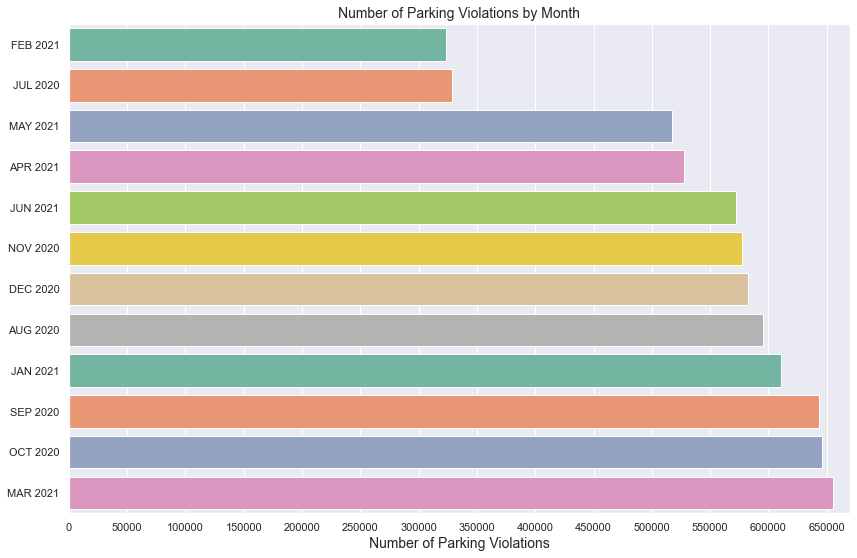

In [8]:
#Beginning and end of fiscal year have least amount of violations
months = pd.DataFrame(df.month_year.value_counts().head(12)).sort_values('month_year')
yvalues = months.index

sns.set(style="darkgrid")
plt.figure(figsize=(14, 9))

sns.barplot(x=months.month_year, y=yvalues, palette='Set2')
plt.title('Number of Parking Violations by Month', size = 14)
plt.xlabel('Number of Parking Violations', size = 14)
plt.xlim(0,670000)
plt.xticks(np.arange(0,660000, 50000))
plt.show()

This may be better depicted as a treeplot:

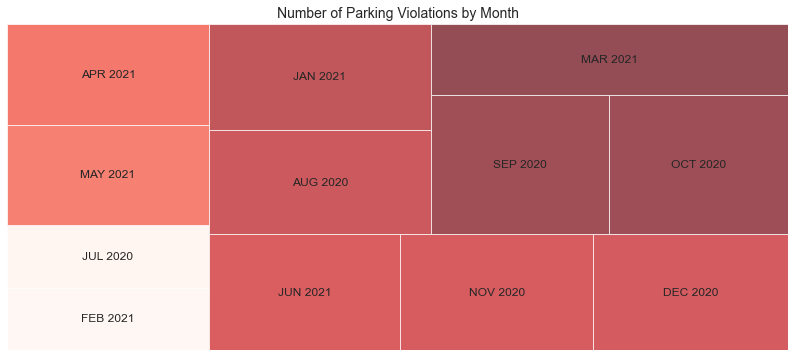

In [9]:
#mapping color palette 
cmap = matplotlib.cm.Reds
mini=min(months.month_year)
maxi=max(months.month_year)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in months.month_year]
#figure size
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)

squarify.plot(sizes=months.month_year, label=yvalues, alpha=.7, color = colors, ax=ax)
plt.title('Number of Parking Violations by Month', size = 14)
plt.axis('off')
plt.show()

A data visualization software such as Tableau or IBM Cognos would be better suited for this type of plot. 
<br>This graph makes it look like September and October had more parking violations than March, with November and December close behind.

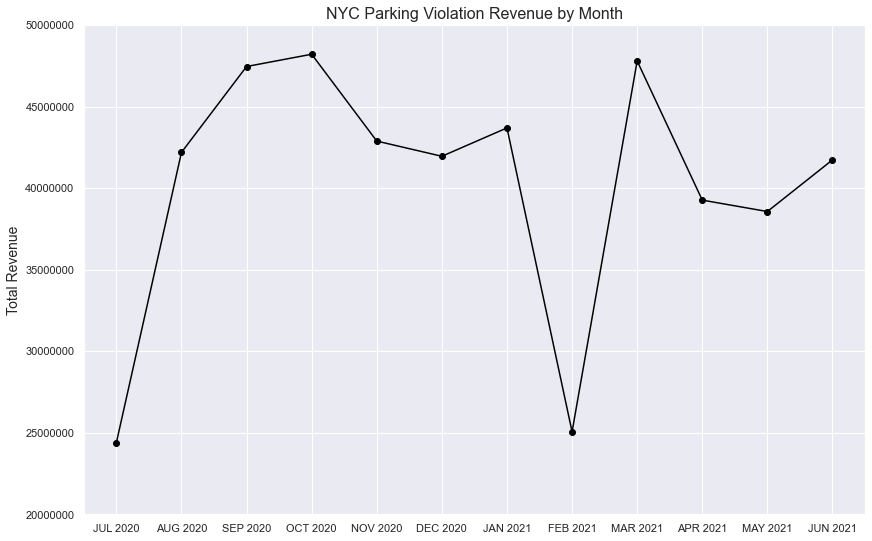

In [10]:
#line chart by month
monthly_rev_sort = df[['issue_date', 'month_year', 'violation_fine']].sort_values('issue_date')
monthly_rev = monthly_rev_sort.groupby(monthly_rev_sort.month_year, sort = False).sum()

xvalues = monthly_rev.index
plt.figure(figsize=(14, 9))
plt.plot(xvalues,monthly_rev.violation_fine, color='black', marker='o')
plt.ylim(20000000,50000001)
plt.xlim(-0.5,11.5)
plt.title('NYC Parking Violation Revenue by Month', size = 16)
plt.ylabel('Total Revenue', size = 14)
plt.ticklabel_format(axis = 'y', style = 'plain')
plt.show()

### Violations by Borough

In [11]:
#Organizing total revenue by Borough
overall_group = df[['violation_county', 'violation_fine']].groupby(df.violation_county).sum().sort_values('violation_fine', ascending = False)

#Organizing our dataset by Borough
nyc = df[df['violation_county'] == 'MANHATTAN']
bklyn = df[df['violation_county'] == 'BROOKLYN']
queens = df[df['violation_county'] == 'QUEENS']
bronx = df[df['violation_county'] == 'BRONX']
staten = df[df['violation_county'] == 'STATEN ISLAND']

In [12]:
#revenue by borough sorted by month ascending 
nyc_rev_sort = nyc[['issue_date', 'month_year', 'violation_fine']].sort_values('issue_date')
nyc_rev = nyc_rev_sort.groupby(nyc_rev_sort.month_year, sort = False).sum()

bklyn_rev_sort = bklyn[['issue_date', 'month_year', 'violation_fine']].sort_values('issue_date')
bklyn_rev = bklyn_rev_sort.groupby(bklyn_rev_sort.month_year, sort = False).sum()

queens_rev_sort = queens[['issue_date', 'month_year', 'violation_fine']].sort_values('issue_date')
queens_rev = queens_rev_sort.groupby(queens_rev_sort.month_year, sort = False).sum()

bronx_rev_sort = bronx[['issue_date', 'month_year', 'violation_fine']].sort_values('issue_date')
bronx_rev = bronx_rev_sort.groupby(bronx_rev_sort.month_year, sort = False).sum()

staten_rev_sort = staten[['issue_date', 'month_year', 'violation_fine']].sort_values('issue_date')
staten_rev = staten_rev_sort.groupby(staten_rev_sort.month_year, sort = False).sum()

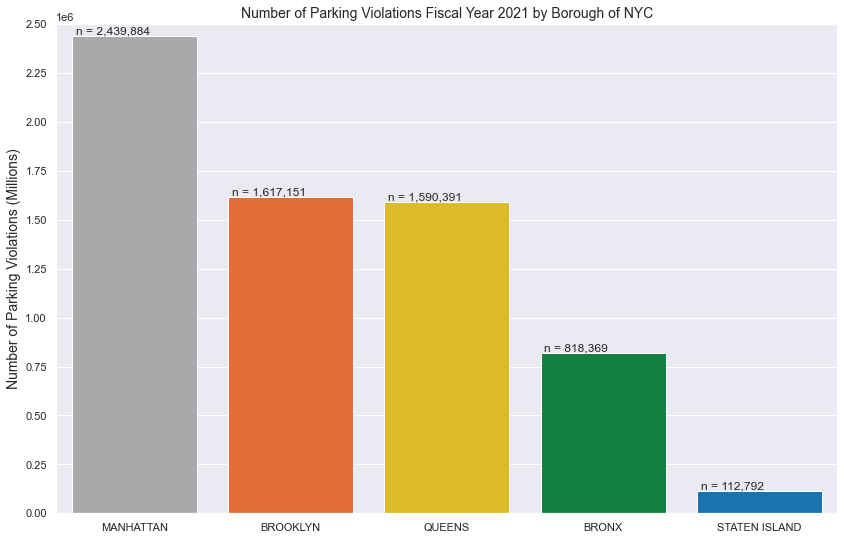

In [13]:
boroughs = pd.DataFrame(df.violation_county.value_counts()).sort_values('violation_county', ascending = False)

xvalues = boroughs.index
xvaluerange = range(len(xvalues))

sns.set(style="darkgrid")
plt.figure(figsize=(14, 9))

sns.barplot(y=boroughs.violation_county, x=xvalues, palette = ['#A7A9AC', '#FF6319', '#FCCC0A', '#00933C', '#0078C6'])
plt.title('Number of Parking Violations Fiscal Year 2021 by Borough of NYC', size = 14)
plt.ylabel('Number of Parking Violations (Millions)', size = 14)
plt.ylim(0,250000)
plt.yticks(np.arange(0,2500001,250000))
label = ['n = 2,439,884','n = 1,617,151','n = 1,590,391','n = 818,369','n = 112,792']
for i in xvaluerange:
    plt.text(x = xvaluerange[i] -.375, y = boroughs.violation_county[i]+10000, s = label[i], size = 12)
plt.show()

Fun fact: the colors chosen are the official MTA hexcodes for a subway line with a terminal in the corresponding borough!
<br>Staten Island has a lot of private parking available (driveways, parking lots) and is not as dense as the other boroughs.


In [14]:
print('Percentage of all 2021 parking violations:')
print('Manhattan:', int(round((2439884/6578587),2) * 100),'%')
print('Brooklyn:', int(round((1617151/6578587),2) * 100),'%')
print('Queens:', int(round((1590391/6578587),2) * 100),'%')
print('Bronx:', int(round((818369/6578587),2) * 100),'%')
print('Staten Island:', int(round((112792/6578587),2) * 100),'%')

Percentage of all 2021 parking violations:
Manhattan: 37 %
Brooklyn: 25 %
Queens: 24 %
Bronx: 12 %
Staten Island: 2 %


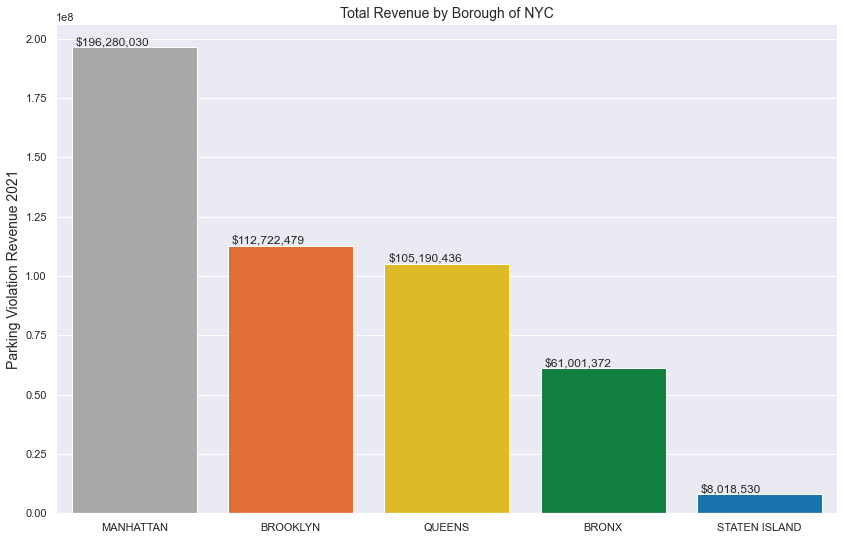

In [15]:
xvalues = overall_group.index
xvaluerange = range(len(xvalues))

sns.set(style="darkgrid")
plt.figure(figsize=(14, 9))

sns.barplot(y=overall_group.violation_fine, x=xvalues, palette = ['#A7A9AC', '#FF6319', '#FCCC0A', '#00933C', '#0078C6'])
plt.title('Total Revenue by Borough of NYC', size = 14)
plt.ylabel('Parking Violation Revenue 2021', size = 14)
plt.xlabel('')
# plt.ylim(0,250000)
# plt.yticks(np.arange(0,2500001,250000))
label = ['$196,280,030','$112,722,479','$105,190,436','$61,001,372','$8,018,530']
for i in xvaluerange:
    plt.text(x = xvaluerange[i] -.375, y = overall_group.violation_fine[i]+900000, s = label[i], size = 12)
plt.show()

In [16]:
print('Percentage of total 2021 parking violation revenue:')
print('Manhattan:', int(round((196280030/483212847),2) * 100),'%')
print('Brooklyn:', int(round((112722479/483212847),2) * 100),'%')
print('Queens:', int(round((105190436/483212847),2) * 100),'%')
print('Bronx:', int(round((61001372/483212847),2) * 100),'%')
print('Staten Island:', int(round((8018530/483212847),2) * 100),'%')

Percentage of total 2021 parking violation revenue:
Manhattan: 41 %
Brooklyn: 23 %
Queens: 22 %
Bronx: 13 %
Staten Island: 2 %


Manhattan, making up 37% of all parking violations in NYC, contributes to 41% of total revenue, which makes sense given the slightly increased fines compared to other boroughs (roughly 5% more expensive).

In [17]:
borough_info = {'Borough':['MANHATTAN','BROOKLYN','QUEENS','BRONX','STATEN ISLAND'],
                'population':[1576876, 2641052, 2331143, 1424948, 493494],
                'area_sqmi':[22.83, 70.82, 108.53, 42.10, 58.37],
                'total_revenue':[nyc.violation_fine.sum(), bklyn.violation_fine.sum(), queens.violation_fine.sum(), bronx.violation_fine.sum(), staten.violation_fine.sum()]}
borough_census = pd.DataFrame(borough_info)
borough_census['pop_density'] = (borough_census.population / borough_census.area_sqmi).round(2)
borough_census.sort_values('pop_density', inplace = True)
borough_census

,Borough,population,area_sqmi,total_revenue,pop_density
4,STATEN ISLAND,493494,58.37,8018530.0,8454.58
2,QUEENS,2331143,108.53,105190436.0,21479.25
3,BRONX,1424948,42.10,61001372.0,33846.75
1,BROOKLYN,2641052,70.82,112722479.0,37292.46
0,MANHATTAN,1576876,22.83,196280030.0,69070.35


Population data derived from <a href="https://www.census.gov/quickfacts/fact/table/bronxcountynewyork,newyorkcountynewyork,queenscountynewyork,kingscountynewyork,richmondcountynewyork/PST045221"> US Census Bureau </a> calculating density using 2021 population estimates and land area of borough.

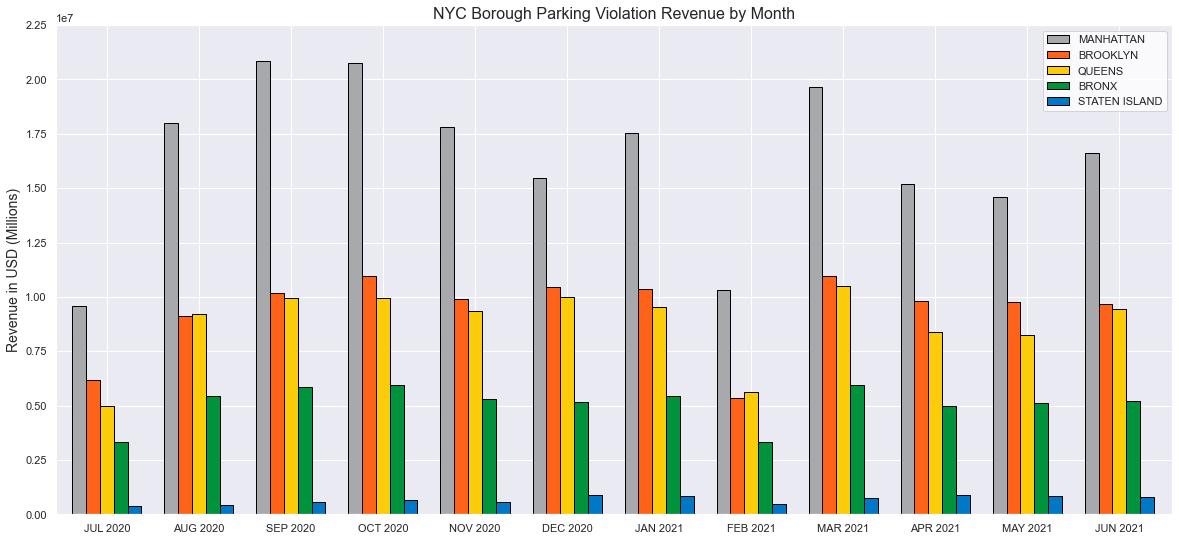

In [18]:
plt.figure(figsize=(20, 9))
barWidth = 0.3
nych = nyc_rev.violation_fine
bklynh = bklyn_rev.violation_fine
queensh = queens_rev.violation_fine
bronxh = bronx_rev.violation_fine
statenh = staten_rev.violation_fine

x1coords = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]
x2coords = [x + barWidth for x in x1coords]
x3coords = [x + barWidth for x in x2coords]
x4coords = [x + barWidth for x in x3coords]
x5coords = [x + barWidth for x in x4coords]

plt.bar(x = x1coords, height = nych, width = barWidth, edgecolor = 'black', color = '#A7A9AC', label = 'MANHATTAN')
plt.bar(x = x2coords, height = bklynh, width = barWidth, edgecolor = 'black', color = '#FF6319', label = 'BROOKLYN')
plt.bar(x = x3coords, height = queensh, width = barWidth, edgecolor = 'black', color = '#FCCC0A', label = 'QUEENS')
plt.bar(x = x4coords, height = bronxh, width = barWidth, edgecolor = 'black', color = '#00933C', label = 'BRONX')
plt.bar(x = x5coords, height = statenh, width = barWidth, edgecolor = 'black', color = '#0078C6', label = 'STATEN ISLAND')

plt.title('NYC Borough Parking Violation Revenue by Month', size = 16)
plt.ylabel('Revenue in USD (Millions)', size = 14)
plt.legend(facecolor = 'white')
plt.xlim(0.5,24.75)
plt.xticks([r + 2 * barWidth for r in x1coords], staten_rev.index)
plt.ylim(0, 22500001)
plt.yticks(np.arange(0,22500001, 2500000))
plt.show()

February 2021 and July 2020 collected signifigantly lower revenue than other months, which is expected given that these 2 months saw the least amount of tickets given in the year.
<br> A <a href= "https://www.kaggle.com/code/yudanc/2017-nyc-parking-ticket-data-visualizationsimilar"> similar analysis</a> of 2017 data also found July to have among the least amount of tickets given, but not February: 
- This could be explained by the <a href= "https://www.ny1.com/nyc/all-boroughs/weather/2021/02/26/this-is-why-nyc-will-remember-this-february-s-weather-for-many-years-to-come"> blizzards of February 2021</a> which saw "24 consecutive days with more than an inch of snow on the ground."

I'm not sure about July 2020, however. Maybe related to first month off from school? 
- More car usage:
  - driving with kids to activities/vacation spots
  - teens using parents' cars more frequently
  
Overall results in less alternate side parking tickets/meter tickets/cars around in general
- Or even less car usage:
  - stored in private parking while owner is away from NYC 

In [20]:
bklyndf = pd.DataFrame(bklynh)
bklyndf['pop_density'] = 37292.46

nycdf = pd.DataFrame(nych)
nycdf['pop_density'] = 69070.35

bronxdf = pd.DataFrame(bronxh)
bronxdf['pop_density'] = 33846.75

statendf = pd.DataFrame(statenh)
statendf['pop_density'] = 8454.58

queensdf = pd.DataFrame(queensh)
queensdf['pop_density'] = 21479.25

all_dens_rev = pd.concat([nycdf, bklyndf, queensdf, bronxdf, statendf])
all_dens_rev.sort_values('pop_density', inplace = True)

In [21]:
print('2021 Manhattan Parking Ticket Revenue by individual:' , round((nycdf.violation_fine.sum() / 1576876), 2))
print('2021 Brooklyn Parking Ticket Revenue by individual:' , round((bklyndf.violation_fine.sum() / 2641052), 2))
print('2021 Queens Parking Ticket Revenue by individual:' , round((queensdf.violation_fine.sum() / 2331143), 2))
print('2021 Bronx Parking Ticket Revenue by individual:' , round((bronxdf.violation_fine.sum() / 1424948), 2))
print('2021 Staten Island Parking Ticket Revenue by individual:' , round((statendf.violation_fine.sum() / 493494), 2))

2021 Manhattan Parking Ticket Revenue by individual: 124.47
2021 Brooklyn Parking Ticket Revenue by individual: 42.68
2021 Queens Parking Ticket Revenue by individual: 45.12
2021 Bronx Parking Ticket Revenue by individual: 42.81
2021 Staten Island Parking Ticket Revenue by individual: 16.25


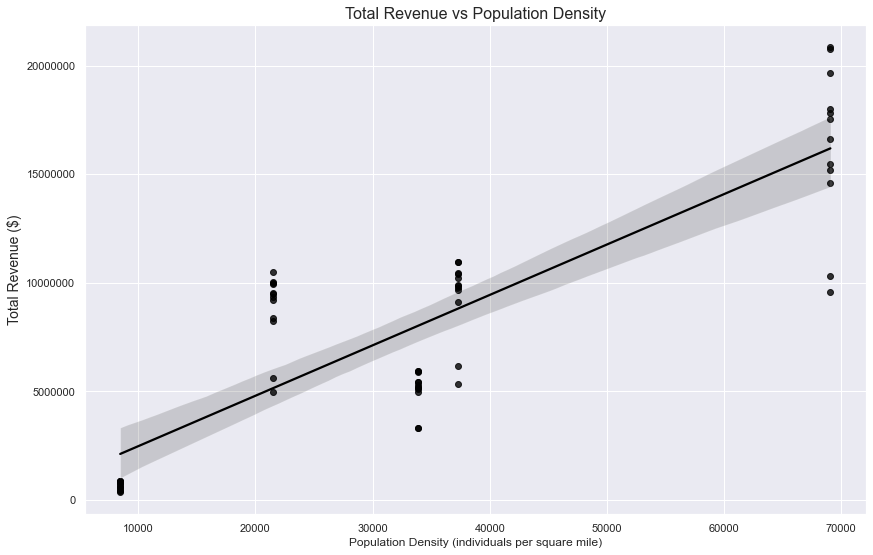

In [22]:
xvalues = all_dens_rev.pop_density
yvalues = all_dens_rev.violation_fine
plt.figure(figsize=(14, 9))
sns.regplot(x=xvalues,y=yvalues,color='black')
plt.title('Total Revenue vs Population Density', size = 16)
plt.ylabel('Total Revenue ($)', size = 14)
plt.xlabel('Population Density (individuals per square mile)')
plt.ticklabel_format(axis = 'y', style = 'plain')
plt.show()

### Violation Types

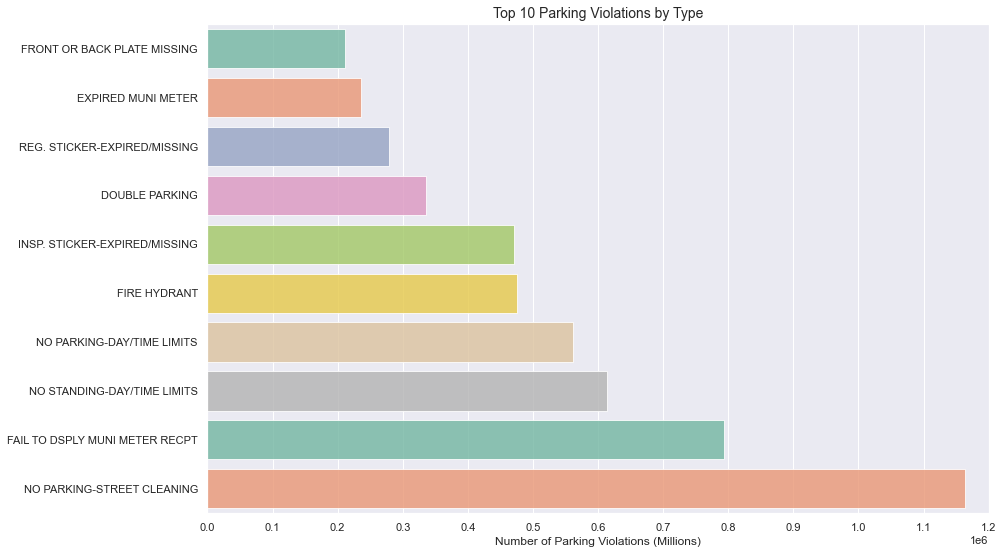

In [23]:
violations = pd.DataFrame(df.violation.value_counts().head(10)).sort_values('violation')
yvalues = violations.index

plt.figure(figsize=(14, 9))

sns.barplot(x=violations.violation, y=yvalues, palette='Set2', alpha = 0.8)
plt.title('Top 10 Parking Violations by Type', size = 14)
plt.xlabel('Number of Parking Violations (Millions)', size = 12)
plt.xlim(0,1200001)
plt.xticks(np.arange(0,1200001, 100000))
plt.show()

#### hierarchal bubble plots for violation type in each borough

In [24]:
borough_types = [{'id': 'NYC', 'datum': 6578587, 'children' : [
              {'id' : "MANHATTAN", 'datum': 1164065,
                   'children' : [
                     {'id' : "NO STANDING", 'datum' : 299224},
                     {'id' : "NO PARKING", 'datum' : 291177},
                     {'id' : "MUNI METER RECPT", 'datum' : 209518},
                     {'id' : "STREET CLEANING", 'datum' : 190764},
                     {'id' : "DOUBLE PARKING", 'datum' : 173382}
                   ]},
              {'id' : "BROOKLYN", 'datum' : 1090836, 
                   'children' : [
                     {'id' : "STREET CLEANING", 'datum' : 475272},
                     {'id' : "MUNI METER RECPT", 'datum' : 184788},
                     {'id' : "FIRE HYDRANT", 'datum' : 152437},
                     {'id' : "INSP. STICKER", 'datum' : 142359},
                     {'id' : "NO STANDING", 'datum' : 135980}
                   ]},
              {'id' : "QUEENS", 'datum' : 983387,  
                   'children' : [
                     {'id' : "STREET CLEANING", 'datum' : 323974},
                     {'id' : "MUNI METER RECPT", 'datum' : 298225},
                     {'id' : "INSP. STICKER", 'datum' : 130644},
                     {'id' : "FIRE HYDRANT", 'datum' : 117673},
                     {'id' : "NO PARKING", 'datum' : 112871}
                   ]},
              {'id' : "BRONX", 'datum' : 493387,  
                   'children' : [
                     {'id' : "STREET CLEANING", 'datum' : 173543},
                     {'id' : "MUNI METER RECPT", 'datum' : 87805},
                     {'id' : "FIRE HYDRANT", 'datum' : 83878},
                     {'id' : "INSP. STICKER", 'datum' : 74905},
                     {'id' : "DOUBLE PARKING", 'datum' : 73256}
                   ]},
              {'id' : "STATEN ISLAND", 'datum' : 85962,  
                   'children' : [
                     {'id' : "INSP. STICKER", 'datum' : 32509},
                     {'id' : "REG. STICKER", 'datum' : 18763},
                     {'id' : "MUNI METER RECPT", 'datum' : 13653},
                     {'id' : "PLATE MISSING", 'datum' : 12343},
                     {'id' : "NO STANDING", 'datum' : 8694}
                   ]}
    ]}]

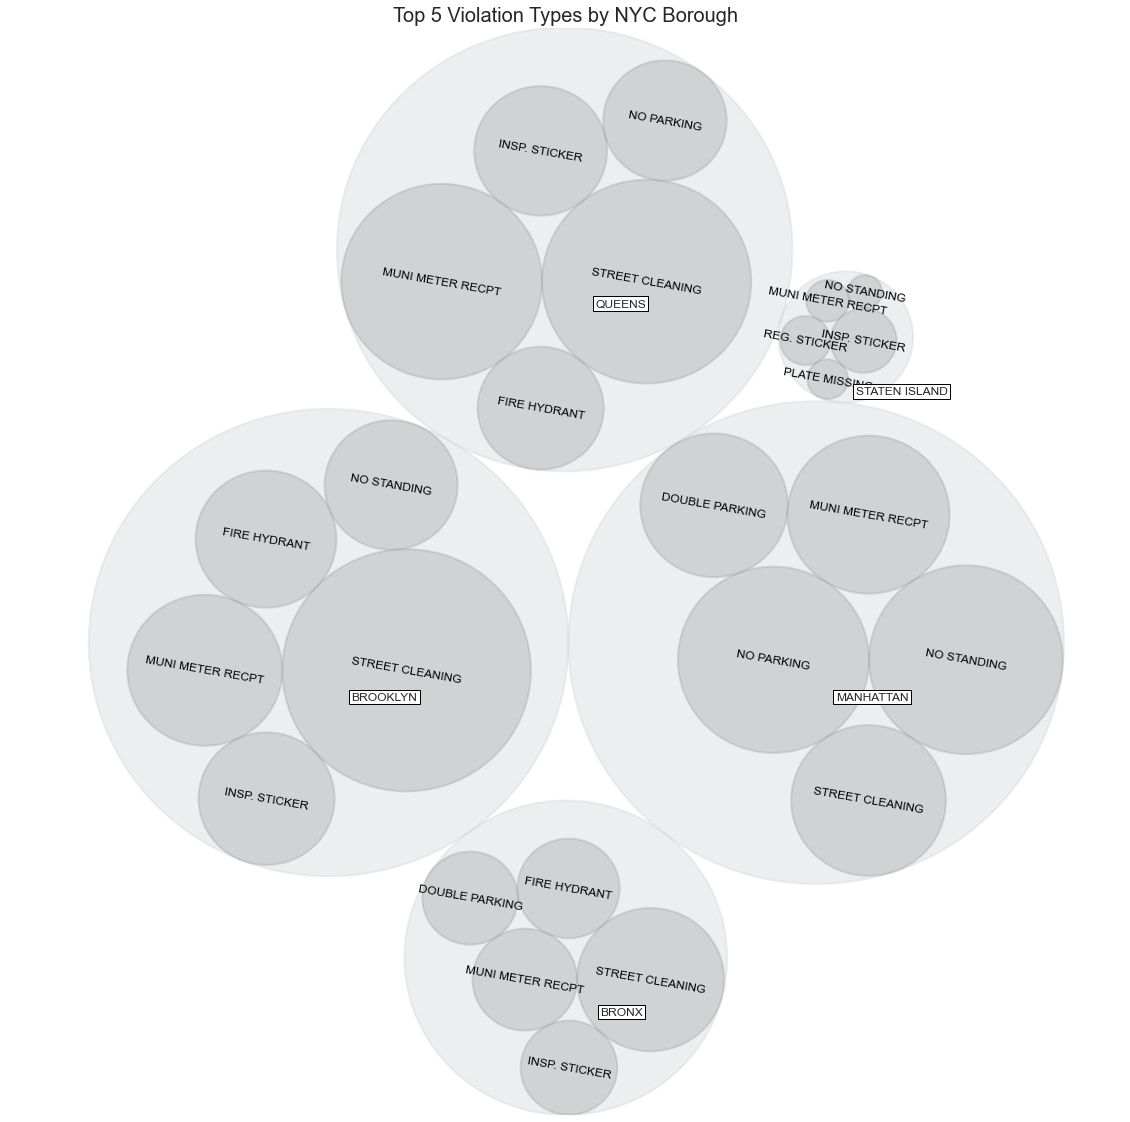

In [25]:
#circle positions via circlify library
circles = circlify.circlify(
    borough_types, 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

fig, ax = plt.subplots(figsize=(20,20))
ax.set_title('Top 5 Violation Types by NYC Borough', size=20)
ax.axis('off')

#axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

#Borough Circles
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    ax.add_patch( plt.Circle((x, y), r, alpha=0.4, linewidth=2, color="#D3D6DB"))
#inner circle labels
for circle in circles:
    if circle.level != 3:
      continue
    x, y, r = circle
    label = circle.ex["id"]
    ax.add_patch( plt.Circle((x, y), r, alpha=0.4, linewidth=2, color="#A7A9AC"))
    plt.annotate(label, (x,y ), va='center', ha='center', color="black", rotation = 350)
    
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    label = circle.ex["id"]
    plt.annotate(label, (x +.1,y + -.1 ) ,va='center', ha='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='square', pad=.2))


Thanks to <a href="https://www.yan-holtz.com"> Yan Holtz</a> for his <a href="https://python-graph-gallery.com/circular-packing-several-levels-of-hierarchy"> tutorial</a>!
<br> A more extensive version below displays top 10 violations for every borough but Staten Island, where the bubble labels became incomprehensible due to size difference.

In [26]:
borough_types = [{'id': 'NYC', 'datum': 6578587, 'children' : [
              {'id' : "MANHATTAN", 'datum': 1877117,
                   'children' : [
                     {'id' : "NO STANDING", 'datum' : 299224},
                     {'id' : "NO PARKING", 'datum' : 291177},
                     {'id' : "MUNI METER RECPT", 'datum' : 377110},
                     {'id' : "STREET CLEANING", 'datum' : 190764},
                     {'id' : "EXPIRED METER", 'datum' : 76753},
                     {'id' : "COMM METER ZONE", 'datum' : 153005},
                     {'id' : "FIRE HYDRANT", 'datum' : 114264},
                     {'id' : "NO STAND EXC TRUCK LOADING", 'datum' : 111117},
                     {'id' : "INSP. STICKER", 'datum' : 90321},
                     {'id' : "DOUBLE PARKING", 'datum' : 173382}
                   ]},
              {'id' : "BROOKLYN", 'datum' : 1415581, 
                   'children' : [
                     {'id' : "STREET CLEANING", 'datum' : 475272},
                     {'id' : "MUNI METER RECPT", 'datum' : 184788},
                     {'id' : "FIRE HYDRANT", 'datum' : 152437},
                     {'id' : "INSP. STICKER", 'datum' : 142359},
                     {'id' : "NO STANDING", 'datum' : 135980},
                     {'id' : "NO PARKING", 'datum' : 93161},
                     {'id' : "REG. STICKER", 'datum' : 77731},
                     {'id' : "NO STAND EXC TRUCK LOADING", 'datum' : 55045},
                     {'id' : "DOUBLE PARKING", 'datum' : 50176},
                     {'id' : "PLATE MISSING", 'datum' : 48632}
                   ]},
              {'id' : "QUEENS", 'datum' : 1395642,  
                   'children' : [
                     {'id' : "STREET CLEANING", 'datum' : 323974},
                     {'id' : "MUNI METER RECPT", 'datum' : 298225},
                     {'id' : "INSP. STICKER", 'datum' : 130644},
                     {'id' : "FIRE HYDRANT", 'datum' : 117673},
                     {'id' : "NO PARKING", 'datum' : 112871},
                     {'id' : "NO STANDING", 'datum' : 111951},
                     {'id' : "EXPIRED METER", 'datum' : 99675},
                     {'id' : "REG. STICKER", 'datum' : 83511},
                     {'id' : "PLATE MISSING", 'datum' : 64646},
                     {'id' : "BUS STOP", 'datum' : 52472}
                   ]},
              {'id' : "BRONX", 'datum' : 710896,  
                   'children' : [
                     {'id' : "STREET CLEANING", 'datum' : 173543},
                     {'id' : "MUNI METER RECPT", 'datum' : 87805},
                     {'id' : "FIRE HYDRANT", 'datum' : 83878},
                     {'id' : "INSP. STICKER", 'datum' : 74905},
                     {'id' : "DOUBLE PARKING", 'datum' : 73256},
                     {'id' : "NO PARKING", 'datum' : 60531},
                     {'id' : "NO STANDING", 'datum' : 57785},
                     {'id' : "REG. STICKER", 'datum' : 41827},
                     {'id' : "PLATE MISSING", 'datum' : 31625},
                     {'id' : "BUS STOP", 'datum' : 25741}
                   ]}
    ]}]

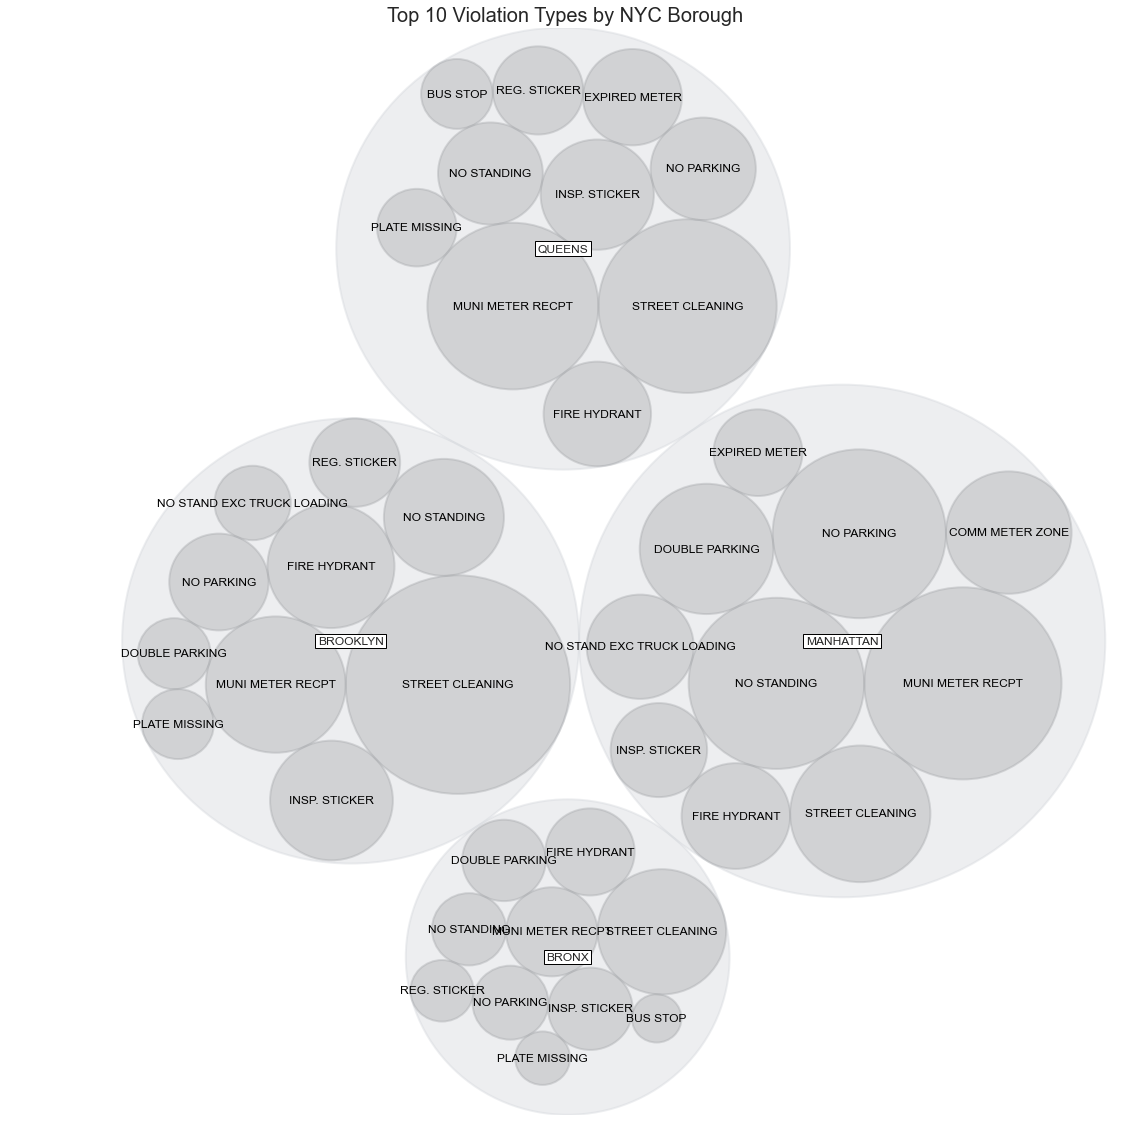

In [27]:
#circle positions via circlify library
circles = circlify.circlify(
    borough_types, 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

fig, ax = plt.subplots(figsize=(20,20))
ax.set_title('Top 10 Violation Types by NYC Borough', size=20)
ax.axis('off')

#axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

#Borough Circles
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    ax.add_patch( plt.Circle((x, y), r, alpha=0.4, linewidth=2, color="#D3D6DB"))
#inner circle labels
for circle in circles:
    if circle.level != 3:
      continue
    x, y, r = circle
    label = circle.ex["id"]
    ax.add_patch( plt.Circle((x, y), r, alpha=0.4, linewidth=2, color="#A7A9AC"))
    plt.annotate(label, (x,y ), va='center', ha='center', color="black")
    
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    label = circle.ex["id"]
    plt.annotate(label, (x,y ) ,va='center', ha='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='square', pad=.2))


Most of the top 10 violations are shared by each borough, namely:
<br> -Parking in a No Standing Zone
<br> -Parking in a No Parking Zone
<br> -Failure to display meter receipt
<br> -Double Parking
<br> -No parking for street cleaning (alternate side parking)
<br> -Registration/Inspection stickers missing/expired
<br> -Parking at a fire hydrant
<br> 
<br> What's interesting is the appearance of "Wrong Way" parking in Staten Island's top 10 where it does not appear in the top 20 for the other boroughs: 


In [28]:
print(staten['violation'].value_counts().head(10))

INSP. STICKER-EXPIRED/MISSING     32509
REG. STICKER-EXPIRED/MISSING      18763
FAIL TO DSPLY MUNI METER RECPT    13653
FRONT OR BACK PLATE MISSING       12343
NO STANDING-DAY/TIME LIMITS        8694
FIRE HYDRANT                       7012
NO PARKING-DAY/TIME LIMITS         4188
EXPIRED MUNI METER                 2535
NO STANDING-BUS STOP               2081
WRONG WAY                          1126
Name: violation, dtype: int64


### 2021 NYC Parking Violations by Precinct

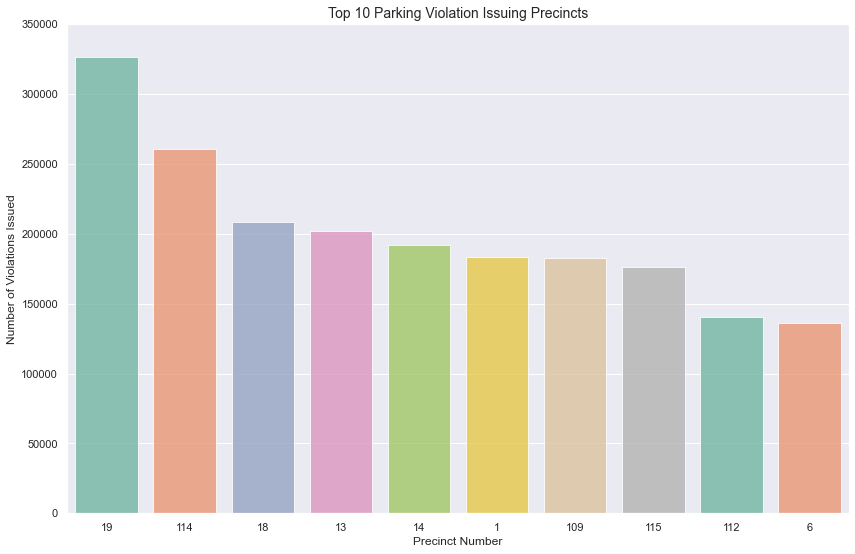

In [29]:
#precinct
precincts = pd.DataFrame(df.violation_precinct.value_counts().head(10)).sort_values('violation_precinct', ascending = False)
xvalues = precincts.index.astype(str)

plt.figure(figsize=(14, 9))

sns.barplot(y=precincts.violation_precinct, x=xvalues, palette='Set2', alpha = 0.8)
plt.title('Top 10 Parking Violation Issuing Precincts', size = 14)
plt.xlabel('Precinct Number', size = 12)
plt.ylabel('Number of Violations Issued')
plt.ylim(0, 350000)
# plt.xlim(0,1200001)
# plt.xticks(np.arange(0,1200001, 100000))
plt.show()


#### Locations of top 10 precincts, descriptions obtained from the <a href="https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page"> NYPD website </a>:
- <b>19th Precinct: Upper East Side Manhattan</b>
<br>"The precinct is one of the most densely populated residential areas in Manhattan. The southern part of the precinct has a large commercial area and features Madison, Lexington, and 3rd Avenues, which are well known for their shopping."
- <b>114th Precinct: Northwestern Queens</b>
<br>"Covers Astoria, Long Island City, Woodside, and Jackson Heights." I've lived by and learned to drive on Steinway Street. Double-parking galore!</br>
- <b>18th Precinct: Midtown North</b>
<br> "The precinct encompasses the Diamond District, St. Patrick's Cathedral, the Theatre District, Restaurant Row, Radio City Music Hall, and Rockefeller Plaza."
- <b>13th Precinct: Southeastern Midtown</b>
<br>"The precinct features the Peter Cooper Village/Stuyvesant Town residential complex, Gramercy Park, the lower portion of Rosehill, Madison Square Park, and Union Square Park."
- <b>14th Precinct: Midtown South</b>
<br>"The area contains commercial offices, hotels, Times Square, Grand Central Terminal, Penn Station, Madison Square Garden, Koreatown section, and the Manhattan Mall Plaza."</br>
- <b>1st Precinct: Southernmost square mile of Manhattan</b>
<br>"The precinct is home to the World Trade Center, SOHO, Tribeca, and Wall Street."</br>
- <b>109th Precinct: Northeastern Queens</b>
<br>"Including Downtown Flushing, East Flushing, Queensboro Hill, College Point, Malba, Whitestone, Beechhurst, and Bay Terrace."</br>
- <b>115th Precinct: Northern Queens</b>
<br>"Encompassing Jackson Heights, East Elmhurst, and North Corona. The precinct patrol responsibilities also include LaGuardia Airport."</br>
- <b>112th Precinct: Central Queens</b>
<br>"Housing Forest Hills and Rego Park."</br>
- <b>6th Precinct: Southwestern Manhattan</b>
<br>"Serves the southwestern Manhattan neighborhoods of Greenwich Village and the West Village."

##### What's interesting about this is the disproportionate representation by Queens precincts compared to its position in overall tickets issued (3rd) and the lack of representation by precincts in Brooklyn.
- 4 of the to 10 are in Queens, the rest Manhattan
<br>This could be a factor of population density within the boroughs. Perhaps the population of Queens is concentrated in a few zones and Brooklyn's population is more dispersed.</br>

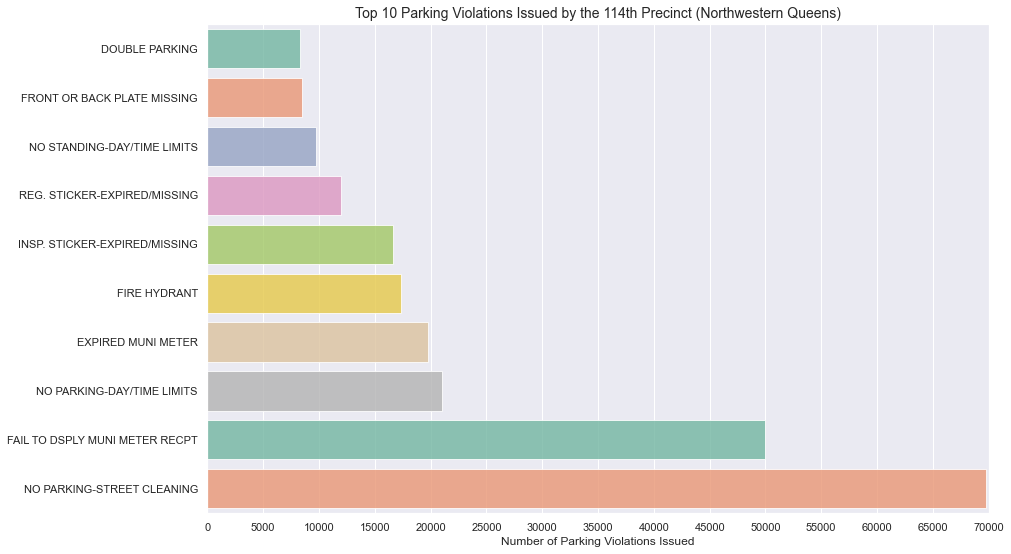

In [31]:
astoria = df[df['violation_precinct'] == 114]
astoria_types = pd.DataFrame(astoria.violation.value_counts().head(10)).sort_values('violation')
yvalues = astoria_types.index

plt.figure(figsize=(14, 9))

sns.barplot(x=astoria_types.violation, y=yvalues, palette='Set2', alpha = 0.8)
plt.title('Top 10 Parking Violations Issued by the 114th Precinct (Northwestern Queens)', size = 14)
plt.xlabel('Number of Parking Violations Issued', size = 12)
plt.xlim(0,70001)
plt.xticks(np.arange(0,70001, 5000))
plt.show()

Based off my experience living there, I'm suprised to see double parking so low on the list, but it still makes the top 10! 
<br>The other violation types are more or less ordered the same as the overall observations.

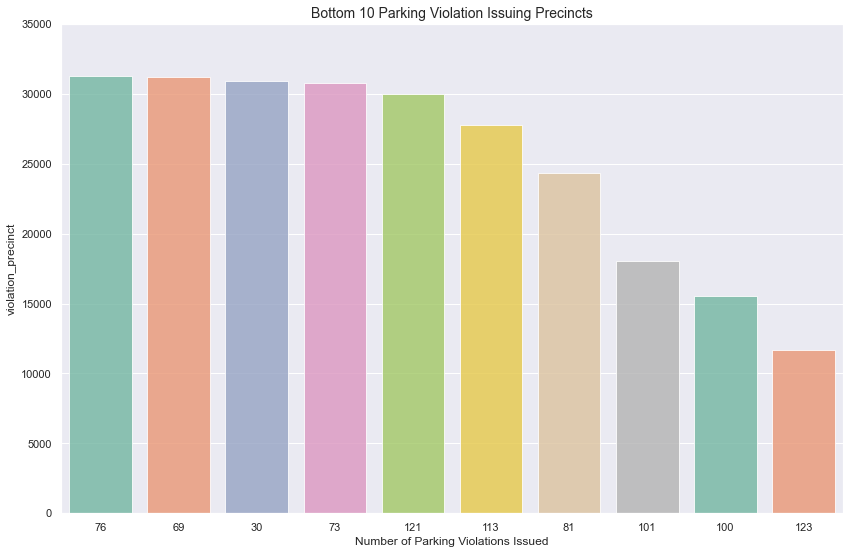

In [32]:
least_precincts = pd.DataFrame(df.violation_precinct.value_counts()).sort_values('violation_precinct', ascending = False)
least_precincts = least_precincts[least_precincts['violation_precinct'] >= 11697].tail(10)
xvalues = least_precincts.index.astype(str)

plt.figure(figsize=(14, 9))

sns.barplot(y=least_precincts.violation_precinct, x=xvalues, palette='Set2', alpha = 0.8)
plt.title('Bottom 10 Parking Violation Issuing Precincts', size = 14)
plt.xlabel('Number of Parking Violations Issued', size = 12)
plt.ylim(0,35001)
plt.show()

- <b>76th Precinct: Southern Brooklyn</b>
<br>"Includes the neighborhoods of Carroll Gardens, Red Hook, Cobble Hill, parts of Gowanus, and the Columbia Street Waterfront District."
- <b>69th Precinct: Eastern Brooklyn</b>
<br>"Serves the Canarsie section of Brooklyn. The precinct is mostly residential with commercial strips along Avenue L, Rockaway Parkway, and Remsen Avenue.</br>
- <b>30th Precinct: Western Harlem</b>
<br> "The neighborhoods covered by the precinct are Hamilton Heights, Sugar Hill, and West Harlem. The precinct contains Riverside Park and Jackie Robinson Park."
- <b>73rd Precinct: Northeastern Brooklyn</b>
<br>"Brownsville and Ocean Hill"
- <b>121st Precinct: Northwestern Staten Island</b>
<br>"Containing Willowbrook, Westerleigh, Port Richmond, Mariner's Harbor, Elm Park, Port Ivory, Chelsea, and Bloomfield."</br>
- <b>113th Precinct: Eastern Queens</b>
<br>"Serves the southeastern area of Jamaica, Queens, along with St. Albans, Hollis, Springfield Gardens, South Ozone Park, South Jamaica, Addisleigh Park, and Locust Manor."</br>
- <b>81st Precinct: Northern Brooklyn</b>
<br>"Containing Bedford Stuyvesent and Stuyvesant Heights"</br>
- <b>101st Precinct: Eastern Rockaways, Queens</b>
<br>"Houses Far Rockaway and Bayswater."</br>
- <b>100th Precinct: Western Rockaways, Queens</b>
<br>"Contains Arverne, Belle Harbor, Breezy Point, Broad Channel, Neponsit, Rockaway Park, Rockaway Beach, and Roxbury.."</br>
- <b>123rd Precinct: Southernmost Staten Island</b>
<br>"Including Tottenville, Huguenot, Rossville, Annadale, and Eltingville."

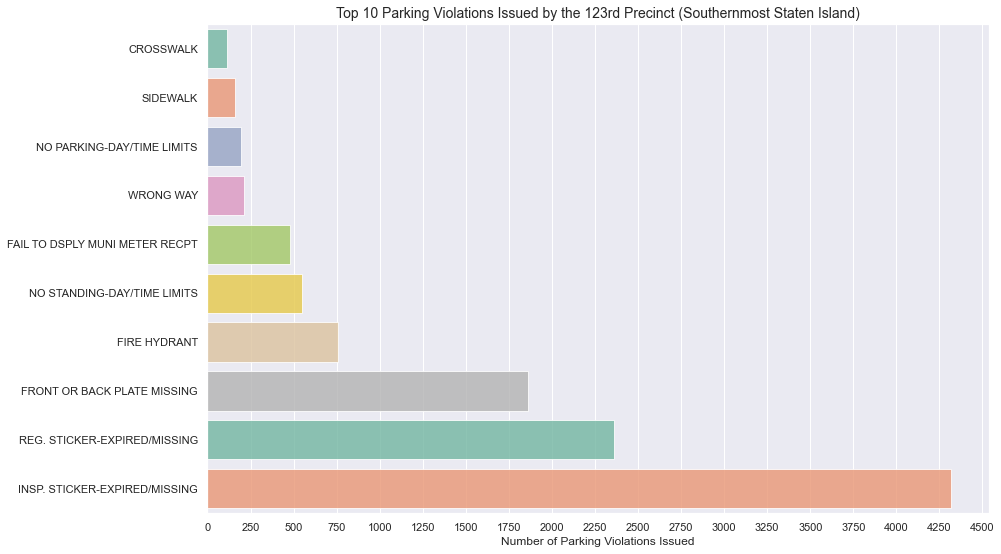

In [33]:
tottenville = df[df['violation_precinct'] == 123]
tottenville_types = pd.DataFrame(tottenville.violation.value_counts().head(10)).sort_values('violation')
yvalues = tottenville_types.index

plt.figure(figsize=(14, 9))

sns.barplot(x=tottenville_types.violation, y=yvalues, palette='Set2', alpha = 0.8)
plt.title('Top 10 Parking Violations Issued by the 123rd Precinct (Southernmost Staten Island)', size = 14)
plt.xlabel('Number of Parking Violations Issued', size = 12)
# plt.xlim(0,70001)
plt.xticks(np.arange(0,4501, 250))
plt.show()

### Vehicle Color Representation in Parking Violations

First we plot top 5 vehicle colors by number of parking violations

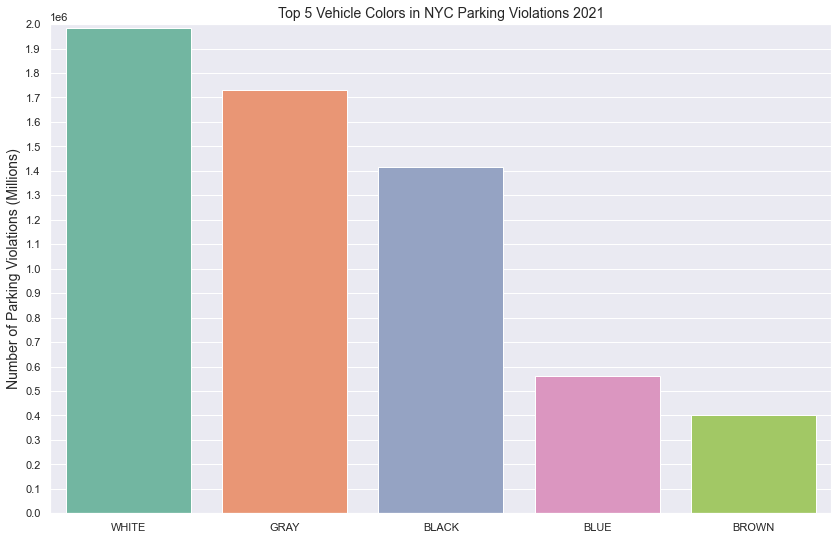

In [34]:
#should compare proportions to most popular car colors in America as side by side bar plot 
colors = pd.DataFrame(df.vehicle_color.value_counts().head(5)).sort_values('vehicle_color', ascending = False)
yvalues = colors.index

sns.set(style="darkgrid")
plt.figure(figsize=(14, 9))

sns.barplot(y=colors.vehicle_color, x=yvalues, palette='Set2')
plt.title('Top 5 Vehicle Colors in NYC Parking Violations 2021', size = 14)
plt.ylabel('Number of Parking Violations (Millions)', size = 14)
plt.ylim(0,2000000)
plt.yticks(np.arange(0,2000001, 100000))
plt.show()

Next we determine how different this representation is compared to an estimation of frequency of vehicle colors in the US.
<br>US car color proportions derived from ISeeCars analysis of over 9.4 million used cars sold in 2019 (https://www.iseecars.com/most-popular-car-colors-study)
<br>We are assuming color trends of NYC/NYS/Other vehicles are equivalent to the US as a whole.

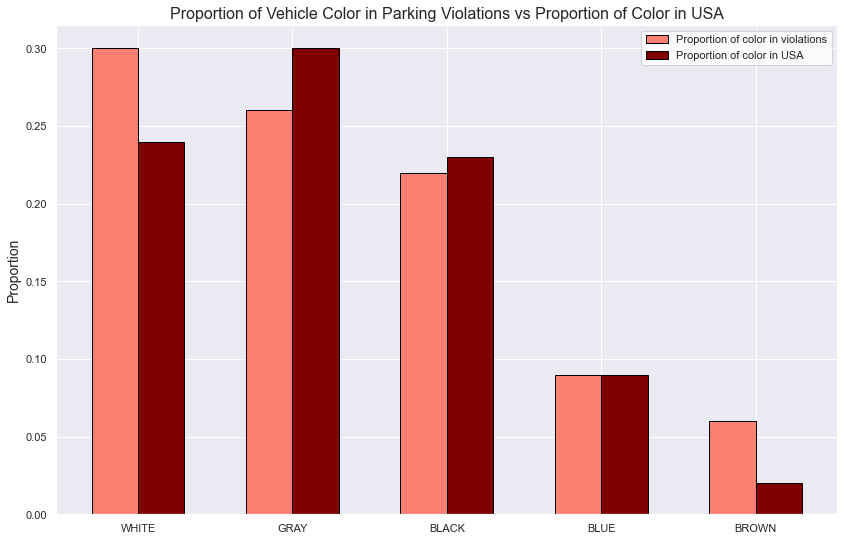

In [35]:
plt.figure(figsize=(14, 9))
barWidth = 0.3
bar1h = [0.30, 0.26, 0.22, 0.09, 0.06]
bar2h = [0.24, 0.30, 0.23, 0.09, 0.02]
x1coords = np.arange(len(yvalues))
x2coords = [x + barWidth for x in x1coords]
plt.bar(x = x1coords, height = bar1h, width = barWidth, edgecolor = 'black', color = 'salmon', label = 'Proportion of color in violations')
plt.bar(x = x2coords, height = bar2h, width = barWidth, edgecolor = 'black', color = 'maroon', label = 'Proportion of color in USA')
plt.title('Proportion of Vehicle Color in Parking Violations vs Proportion of Color in USA', size = 16)
plt.ylabel('Proportion', size = 14)
plt.legend(facecolor = 'white')
plt.xticks([r + 0.5 * barWidth for r in range(len(bar1h))], ['WHITE', 'GRAY', 'BLACK', 'BLUE', 'BROWN'])
plt.show()

The trends in NYC are more or less aligned with population of these car colors in the US, so no, you are not more likely to get a parking ticket just because your car is in a grayscale color!

In [36]:
colors['Proportion'] = (colors['vehicle_color'] / len(df)).round(decimals = 2)
colors['proportion_usa'] = ['0.24','0.30', '0.23', '0.09','0.02']
colors

,vehicle_color,Proportion,proportion_usa
WHITE,1985130,0.30,0.24
GRAY,1730513,0.26,0.30
BLACK,1416740,0.22,0.23
BLUE,562522,0.09,0.09
BROWN,402286,0.06,0.02


In [ ]:
#violation time "when are most offenders getting caught?"

In [37]:
df.head()

,summons_number,registration_state,plate_type,issue_date,violation_fine,vehicle_body_type,vehicle_make,violation_precinct,issuer_code,violation_time,violation_county,house_number,street_name,vehicle_color,vehicle_year,violation,month_year,address
0,1471514882,NEW YORK,PASSENGER,2020-07-01,95.0,SUBURBAN,FORD,102,949909,12:00 PM,QUEENS,81-02,ROCKAWAY BLVD,WHITE,1998,OBSTRUCTING DRIVEWAY,JUL 2020,81-02 ROCKAWAY BLVD QUEENS
1,1471514894,NEW YORK,PASSENGER,2020-07-01,95.0,SUBURBAN,NISSA,102,949969,01:00 PM,QUEENS,87-34,132 ST,RED,2018,OBSTRUCTING DRIVEWAY,JUL 2020,87-34 132 ST QUEENS
2,1471514900,NEW YORK,PASSENGER,2020-07-01,95.0,SUBURBAN,INFIN,102,949969,02:00 PM,QUEENS,87-45,112 ST,BLACK,2004,OBSTRUCTING DRIVEWAY,JUL 2020,87-45 112 ST QUEENS
3,1473991845,NEW YORK,PASSENGER,2020-07-01,115.0,SUBURBAN,INFIN,40,952829,04:00 PM,BRONX,418,E 138 ST,BLACK,2008,BIKE LANE,JUL 2020,418 E 138 ST BRONX
4,1473991857,NEW YORK,PASSENGER,2020-07-01,115.0,SUBURBAN,HYUN,40,952829,04:00 PM,BRONX,416,E 138 ST,WHITE,2012,BIKE LANE,JUL 2020,416 E 138 ST BRONX
